In [1]:
import sys
# Find jVMC package
sys.path.append(sys.path[0] + "/..")

import jax
from jax.config import config
config.update("jax_enable_x64", True)

import jax.random as random
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import jVMC

# DMRG energies produced with the TeNPy library https://github.com/tenpy/tenpy
DMRG_energies = {"10": -1.0545844370449059, "20":-1.0900383739, "100":-1.1194665474274852}

In [2]:
L = 10
g = -0.7

# Initialize net
net = jVMC.nets.CpxRBM(numHidden=8, bias=False)
params = net.init(jax.random.PRNGKey(1234), jnp.zeros((L,), dtype=np.int32))

psi = jVMC.vqs.NQS(net, params)  # Variational wave function

In [3]:
# Set up hamiltonian
hamiltonian = jVMC.operator.BranchFreeOperator()
for l in range(L-1):
    hamiltonian.add(jVMC.operator.scal_opstr(-1., (jVMC.operator.Sz(l), jVMC.operator.Sz((l + 1) % L))))
    hamiltonian.add(jVMC.operator.scal_opstr(g, (jVMC.operator.Sx(l), )))
hamiltonian.add(jVMC.operator.scal_opstr(g, (jVMC.operator.Sx(L-1), )))

In [4]:
# Set up sampler
sampler = jVMC.sampler.MCSampler(psi, (L,), random.PRNGKey(4321), updateProposer=jVMC.sampler.propose_spin_flip_Z2,
                                 numChains=100, sweepSteps=L,
                                 numSamples=5000, thermalizationSweeps=25)

# Set up TDVP
tdvpEquation = jVMC.util.tdvp.TDVP(sampler, rhsPrefactor=1.,
                                   svdTol=1e-8, diagonalShift=10, makeReal='real')

stepper = jVMC.util.stepper.Euler(timeStep=1e-2)  # ODE integrator

In [5]:
res = []
for n in range(300):

    dp, _ = stepper.step(0, tdvpEquation, psi.get_parameters(), hamiltonian=hamiltonian, psi=psi, numSamples=None)
    psi.set_parameters(dp)

    print(n, jax.numpy.real(tdvpEquation.ElocMean0) / L, tdvpEquation.ElocVar0 / L)

    res.append([n, jax.numpy.real(tdvpEquation.ElocMean0) / L, tdvpEquation.ElocVar0 / L])

0 -0.7075186665280421 0.8817714658493564
1 -0.7040029153016988 0.8664474913443969
2 -0.7051592113896447 0.9110625525051447
3 -0.7103593168217657 0.9020953327979996
4 -0.7201794179583099 0.8739738748865543
5 -0.717535017196876 0.8677148978604388
6 -0.7232233650327116 0.8631428230540082
7 -0.7260716346878611 0.8761457130417225
8 -0.7318476904453858 0.8503105759543053
9 -0.7362293233466279 0.816153161678853
10 -0.7360924164965381 0.8367496631034305
11 -0.7388153019700425 0.8347048550699366
12 -0.7494479413152172 0.8182521998062754
13 -0.7480901386148083 0.7923805953255875
14 -0.748385751043777 0.8094448221373838
15 -0.7565987436440433 0.7921170619671456
16 -0.7649706725927489 0.8295592509070129
17 -0.7687971031561811 0.7820372370159565
18 -0.766079189425102 0.7713520333579942
19 -0.7761464486670812 0.7662943698785541
20 -0.7728966494522084 0.734868173718466
21 -0.7813580536007675 0.7399900717795932
22 -0.7798638519748963 0.749156190730306
23 -0.7896902835468042 0.742654261567625
24 -0.790

192 -1.0424751325448434 0.05428436538877712
193 -1.042796959461187 0.05451940423429347
194 -1.0431442807316427 0.04927606581946126
195 -1.0439449010425759 0.04736250466717656
196 -1.0451775546073478 0.04745180465217221
197 -1.043496645629109 0.051895692314719064
198 -1.0436403863108563 0.048311538548492086
199 -1.0447759181261356 0.04852384087415983
200 -1.0438263776785426 0.04997617386011123
201 -1.0451745999616417 0.04517056184717438
202 -1.0456887440568556 0.045378496840202696
203 -1.0434375474382767 0.05253040228810581
204 -1.0444799562068767 0.04448863332130115
205 -1.0451043382466456 0.04640596123623665
206 -1.0443811133432201 0.04505367571692031
207 -1.0450725451936893 0.04708342567886711
208 -1.0448958291714403 0.04624741368714545
209 -1.0433703743384737 0.04580391457620041
210 -1.0447582621091027 0.04319654307550771
211 -1.0441249187131 0.04399577927779743
212 -1.0437507113371338 0.04120391096950132
213 -1.0458725334443926 0.04146990878243147
214 -1.044033073628862 0.045016936

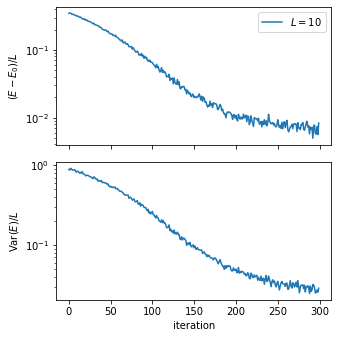

In [6]:
res = np.array(res)

fig, ax = plt.subplots(2,1, sharex=True, figsize=[4.8,4.8])
if str(L) in DMRG_energies:
    ax[0].semilogy(res[:, 0], res[:, 1] - DMRG_energies[str(L)], '-', label=r"$L="+str(L)+"$")
    ax[0].set_ylabel(r'$(E-E_0)/L$')
else:
    ax[0].plot(res[:, 0], res[:, 1], '-')
    ax[0].set_ylabel(r'$E/L$')

ax[1].semilogy(res[:, 0], res[:, 2], '-')
ax[1].set_ylabel(r'Var$(E)/L$')
ax[0].legend()
plt.xlabel('iteration')
plt.tight_layout()
plt.savefig('gs_search.pdf')